# Import Required Packages

In [352]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torch.backends.cudnn as cudnn
import torchvision
import torchvision.transforms as transforms
import numpy as np
import os
import argparse

import boto3
import pandas as pd
from sagemaker import get_execution_role
import sagemaker

# S3 Core Connections

In [178]:
# Create Transforms

transform_train = transforms.Compose(
        [transforms.ToTensor(),
         transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

In [6]:
# Setup system parameters

sess = sagemaker.Session()
role = get_execution_role()
bucket= 'dlbucket435'
data_key = 'cifar-10-python.tar.gz'
model_out = 'model_1'
data_location = 's3://{}/{}'.format(bucket, data_key)
download_in = './cifar'

In [179]:
# Loading example for a CIFAR10 local Dataset and/or fresh dataset download with transformation

trainset = torchvision.datasets.CIFAR10(root=download_in, train=True, download=True, transform=transform_train)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=128, shuffle=True, num_workers=2)

Files already downloaded and verified


In [ ]:
# Unzip local version of CIFAR-10 dataset(we can use the AWS version of cifar10)

!tar -zcvf cifar_10.tar.gz ./cifar

In [ ]:
# Setup Data Location

!aws s3 cp /home/ec2-user/SageMaker/AWS-Pipeline/cifar_10.tar.gz $data_location

In [ ]:
# Setup output classes

classes = ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

In [205]:
# Raw Data Uploaded to S3 to be downloaded by the estimator's fit function later on during training with inputs URI

inputs = sess.upload_data(path='cifar', bucket=bucket)
print('input spec (in this case, just an S3 path): {}'.format(inputs))

input spec (in this case, just an S3 path): s3://dlbucket435/data


# Model Training Connections

In [206]:
from sagemaker.pytorch import PyTorch

# Connect to our own pytortch_cifar.py file

estimator = PyTorch(entry_point='pytorch_cifar.py',
                            role=role,
                            framework_version='1.0.0',
                            train_instance_count=1,
                            train_instance_type='ml.c4.8xlarge',
                            output_path='s3://dlbucket435/model/'
                            )

In [ ]:
estimator.fit({'training':inputs})

# Trained Model Validation

In [219]:
!aws s3 cp s3://dlbucket435/model/sagemaker-pytorch-2019-03-18-09-59-04-255/output/model.tar.gz ./trained-model/

download: s3://dlbucket435/model/sagemaker-pytorch-2019-03-18-09-59-04-255/output/model.tar.gz to trained-model/model.tar.gz


In [350]:
# Define the associated models to import the trained weights

cfg = {
    'VGG11': [64, 'M', 128, 'M', 256, 256, 'M', 512, 512, 'M', 512, 512, 'M'],
    'VGG13': [64, 64, 'M', 128, 128, 'M', 256, 256, 'M', 512, 512, 'M', 512, 512, 'M'],
    'VGG16': [64, 64, 'M', 128, 128, 'M', 256, 256, 256, 'M', 512, 512, 512, 'M', 512, 512, 512, 'M'],
    'VGG19': [64, 64, 'M', 128, 128, 'M', 256, 256, 256, 256, 'M', 512, 512, 512, 512, 'M', 512, 512, 512, 512, 'M'],
    }

class VGG(nn.Module):

    def __init__(self, vgg_name):
        super(VGG, self).__init__()
        self.features = self._make_layers(cfg[vgg_name])
        self.classifier = nn.Linear(512, 10)

    def forward(self, x):
        out = self.features(x)
        out = out.view(out.size(0), -1)
        out = self.classifier(out)
        return out

    def _make_layers(self, cfg):
        layers = []
        in_channels = 3
        for x in cfg:
            if x == 'M':
                layers += [nn.MaxPool2d(kernel_size=2, stride=2)]
            else:
                layers += [nn.Conv2d(in_channels, x, kernel_size=3, padding=1),
                           nn.BatchNorm2d(x),
                           nn.ReLU(inplace=True)]
                in_channels = x
        layers += [nn.AvgPool2d(kernel_size=1, stride=1)]
        return nn.Sequential(*layers)
    
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(3, 32, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(32, 64, 5)
        self.fc1 = nn.Linear(64 * 5 * 5, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(-1, 64 * 5 * 5)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

    
# Load in the trained weights for our beefy lenet model
    
model = Net()
model.load_state_dict(torch.load('./model_beef_lenet/final.pth'))
# model = torch.load('/home/ec2-user/SageMaker/AWS-Pipeline/trained-model/final.pth')
model.eval()
for param in model.parameters():
    print(param.data)

tensor([[[[-0.0742,  0.0849, -0.1616,  0.0409,  0.0541],
          [-0.0316,  0.1413, -0.1998, -0.1348,  0.1770],
          [-0.0554,  0.2041, -0.2089, -0.2185,  0.2258],
          [-0.0109,  0.1503, -0.2180, -0.0872,  0.2777],
          [-0.0957,  0.1348, -0.0814, -0.0679,  0.1398]],

         [[ 0.0698, -0.0639, -0.1316, -0.0828,  0.0831],
          [-0.0726,  0.1654, -0.2730, -0.0005,  0.2598],
          [-0.0457,  0.2495, -0.3504, -0.0956,  0.1390],
          [ 0.0068,  0.1789, -0.2776, -0.1829,  0.0888],
          [ 0.0105,  0.1118, -0.2890, -0.1350,  0.1999]],

         [[ 0.0910,  0.2022, -0.1426, -0.0497, -0.0036],
          [ 0.1311,  0.2513, -0.2078, -0.1130, -0.0084],
          [ 0.1354,  0.1562, -0.2638, -0.1271,  0.1898],
          [ 0.0946,  0.2567, -0.1514, -0.1062,  0.1646],
          [ 0.1316,  0.0341, -0.1039, -0.1733,  0.0735]]],


        [[[-0.0556,  0.0374, -0.1122,  0.1261,  0.0967],
          [-0.1089, -0.2294, -0.0603, -0.1928, -0.1631],
          [-0.2441, -0.

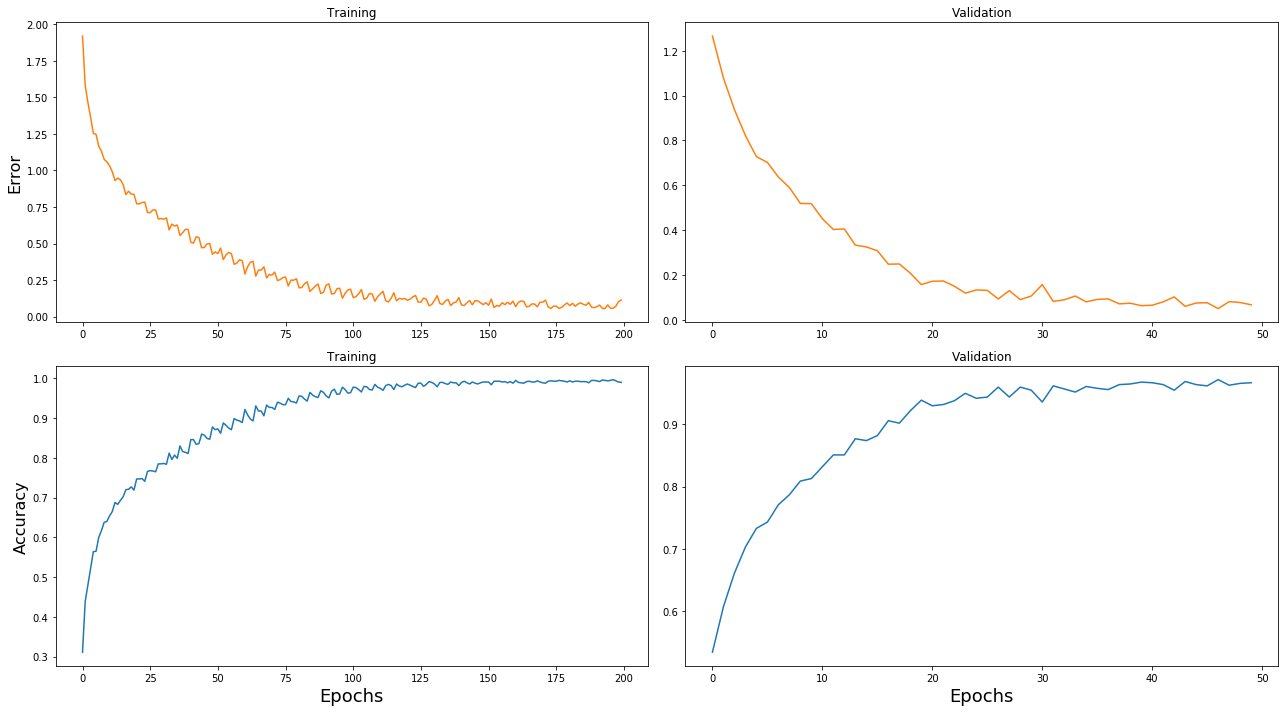

In [344]:
# In this cell we have displayed our "beefy lenet" training and validation error and accuracies


import matplotlib.pyplot as plt

with open('./model_beef_lenet/training_log_format.txt', 'r') as tr_lg:
    lg_data = [x.strip().split(',') for x in tr_lg.readlines()]
    val_acc = []
    acc = []
    val_err = []
    err = []
    for row in lg_data:
        acc_split = row[-1].split(':')
        err_split = row[-2].split(':')
        if acc_split[0] == 'acc':
            acc.append(float(acc_split[1]))
        else:
            val_acc.append(float(acc_split[1]))
            
        if err_split[0] == 'loss':
            err.append(float(err_split[1]))
        else:
            val_err.append(float(err_split[1]))
            
fig = plt.figure(figsize=(18, 10))

ax = plt.subplot(2, 2, 1)
plt.title("Training")
plt.ylabel('Error', fontsize=16)
plt.plot(err, color="C1")

plt.subplot(2, 2, 2)
plt.title("Validation")
plt.plot(val_err,color="C1")

plt.subplot(2, 2, 3)
plt.title("Training")
plt.xlabel('Epochs', fontsize=18)
plt.ylabel('Accuracy', fontsize=16)
plt.plot(acc)

plt.subplot(2, 2, 4)
plt.title("Validation")
plt.xlabel('Epochs', fontsize=18)
plt.plot(val_acc)

plt.tight_layout()
plt.show()

# Model Deployment

In [ ]:
# Make sure Sagemaker Deployment packcages are available
from sagemaker.pytorch import PyTorch
from sagemaker.pytorch import PyTorchModel
from sagemaker import get_execution_role

role = get_execution_role()



# Modified Lenet Deployment - Currently not in use
# pytorch_model = PyTorchModel(model_data='s3://dlbucket435/model/sagemaker-pytorch-2019-03-16-08-46-14-569/output/model.tar.gz', role=role,
#                              entry_point='pytorch_cifar.py')

pytorch_model = PyTorchModel(model_data='s3://dlbucket435/model/sagemaker-pytorch-2019-03-18-09-59-04-255/output/model.tar.gz', role=role,
                             entry_point='pytorch_cifar.py')

predictor = pytorch_model.deploy(instance_type='ml.c4.8xlarge', initial_instance_count=1)


In [ ]:
# Display the content_type for the predictor - helpful in debugging endpoint connections

predictor.content_type

In [353]:
# Utilize for endpoint connection if desired

# predictor.delete_endpoint()